# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import glob
from scipy.interpolate import interp1d
from scipy import stats
from math import radians, cos, sin, asin, sqrt

# Import csv files

In [2]:
# Removed files with 0mb and also 2019. We want to know 2020-10 tm 2020-12 for now.
files = glob.glob(r'GVB/*.csv')
gvb_data = pd.concat( (pd.read_csv(file, sep=";") for file in files), ignore_index = True)
gvb_data

,Datum,UurgroepOmschrijving (van aankomst),AankomstHalteCode,AankomstHalteNaam,AankomstLat,AankomstLon,AantalReizen
0,10/31/2020 12:00:00 AM,18:00 - 18:59,NaN,Overig,NaN,NaN,1
1,11/30/2020 12:00:00 AM,00:00 - 00:59,NaN,Overig,NaN,NaN,4
2,11/30/2020 12:00:00 AM,01:00 - 01:59,NaN,Overig,NaN,NaN,53
3,11/30/2020 12:00:00 AM,02:00 - 02:59,NaN,Overig,NaN,NaN,49
4,11/30/2020 12:00:00 AM,03:00 - 03:59,NaN,Overig,NaN,NaN,30
...,...,...,...,...,...,...,...
3272642,10/24/2021 12:00:00 AM,23:00 - 23:59,WLP,Waterlooplein,4.902982,52.366979,47
3272643,10/24/2021 12:00:00 AM,23:00 - 23:59,WPP,Weesperplein,4.907875,52.361201,53
3272644,10/24/2021 12:00:00 AM,23:00 - 23:59,WTC,Station Zuid,4.875099,52.339080,213
3272645,10/25/2021 12:00:00 AM,00:00 - 00:59,[[ Onb,[[ Onbekend ]],0.000000,0.000000,189


In [3]:
# Read Resono data for later
resono = pd.read_csv("Resono_all.csv")
resono

,Unnamed: 0,Location,Locationcode,Start,End,Visits,Start_Dates,Start_Time,End_Dates,End_Time
0,204,Sarphatipark,0549b281-0465-407b-b76f-e0259a6a8348,2020-09-30T00:00:00+00:00,2020-09-30T00:14:59+00:00,3,2020-09-30,00:00:00,2020-09-30,00:14:59
1,205,Sarphatipark,0549b281-0465-407b-b76f-e0259a6a8348,2020-09-30T00:15:00+00:00,2020-09-30T00:29:59+00:00,2,2020-09-30,00:15:00,2020-09-30,00:29:59
2,206,Sarphatipark,0549b281-0465-407b-b76f-e0259a6a8348,2020-09-30T00:30:00+00:00,2020-09-30T00:44:59+00:00,2,2020-09-30,00:30:00,2020-09-30,00:44:59
3,207,Sarphatipark,0549b281-0465-407b-b76f-e0259a6a8348,2020-09-30T00:45:00+00:00,2020-09-30T00:59:59+00:00,2,2020-09-30,00:45:00,2020-09-30,00:59:59
4,208,Sarphatipark,0549b281-0465-407b-b76f-e0259a6a8348,2020-09-30T01:00:00+00:00,2020-09-30T01:14:59+00:00,1,2020-09-30,01:00:00,2020-09-30,01:14:59
...,...,...,...,...,...,...,...,...,...,...
339245,4803707,Vondelpark Oost,581b90d8-cd25-4bd4-9ae7-1b063aed2c29,2021-02-21T23:30:00+00:00,2021-02-21T23:44:59+00:00,708,2021-02-21,23:30:00,2021-02-21,23:44:59
339246,4803709,Vondelpark West,2deaade4-d687-47da-8c86-12c3f070f3d5,2021-02-21T23:30:00+00:00,2021-02-21T23:44:59+00:00,211,2021-02-21,23:30:00,2021-02-21,23:44:59
339247,4804043,Oosterpark,9aa5b4ac-505e-4da6-977d-edc87469781d,2021-02-21T23:30:00+00:00,2021-02-21T23:44:59+00:00,245,2021-02-21,23:30:00,2021-02-21,23:44:59
339248,4804073,Westergasfabriek,1dd13bd7-2692-43bd-aaff-af55efcf5023,2021-02-21T23:30:00+00:00,2021-02-21T23:44:59+00:00,1,2021-02-21,23:30:00,2021-02-21,23:44:59


# Preprocess GVB data

In [4]:
# Set dates to datetime
# Only select data from 10-2020 till 12-2021
# Drop if destination is unknown
# Remove NaN and [[ Onbekend ]] values
gvb_data['Datum'] = pd.to_datetime(gvb_data['Datum'])
gvb_data = gvb_data.sort_values(by=['Datum', 'UurgroepOmschrijving (van aankomst)'])
gvb_data_range = gvb_data[(gvb_data['Datum'] >= '2020-10-1') & (gvb_data['Datum'] <= '2021-12-31')]
gvb_data_range_cleaned = gvb_data_range[gvb_data_range['AankomstHalteCode'].notnull()]
gvb_data_range_cleaned = gvb_data_range_cleaned[gvb_data_range_cleaned['AankomstHalteNaam'] != "[[ Onbekend ]]"]
gvb_data_range_cleaned.head()

,Datum,UurgroepOmschrijving (van aankomst),AankomstHalteCode,AankomstHalteNaam,AankomstLat,AankomstLon,AantalReizen
244709,2020-10-01,00:00 - 00:59,05011,Centraal Station,4.899218,52.378108,22
244710,2020-10-01,00:00 - 00:59,05022,Centraal Station,4.901043,52.377720,14
244711,2020-10-01,00:00 - 00:59,08247,Vennepluimstraat,4.990572,52.357697,11
244712,2020-10-01,00:00 - 00:59,ASA,Amstelstation,4.917514,52.346473,28
244713,2020-10-01,00:00 - 00:59,ASW,Amstelveenseweg,4.857983,52.338367,12


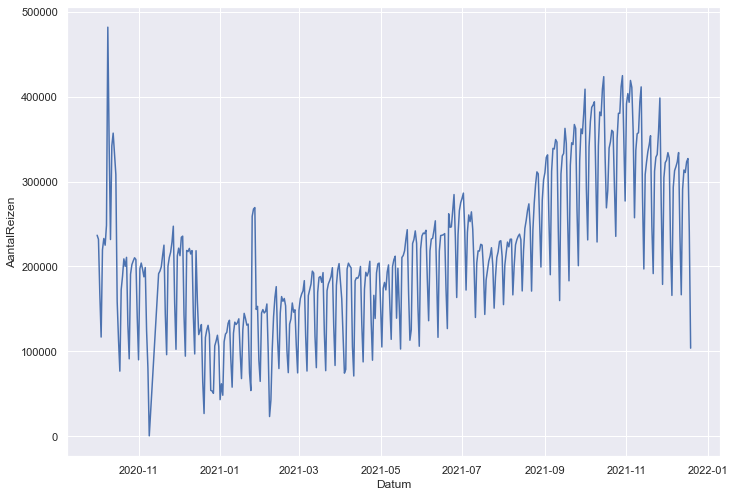

In [5]:
gvb_data_range_cleaned_travellers_per_day = gvb_data_range_cleaned.groupby(['Datum']).sum().reset_index()
gvb_data_range_cleaned_travellers_per_day.head()

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="Datum", y="AantalReizen", data=gvb_data_range_cleaned_travellers_per_day);

In [6]:
# Strange, there seems to be missing data 2020-11-08, let's check this. 395 is very very low, so let's replace
# this outlier with one week before
gvb_data_range_cleaned_travellers_per_day.set_index('Datum')["2020-11"]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,AankomstLat,AankomstLon,AantalReizen
Datum,,,
2020-11-01,12702.356859,136028.470307,89996
2020-11-02,24511.491338,262426.020935,197347
2020-11-03,25084.545785,268550.383348,203996
2020-11-04,24236.090222,259493.620806,196745
2020-11-05,23355.420156,250067.793310,187776
2020-11-06,24050.847712,257500.428780,198735
2020-11-07,16397.032755,175557.136745,124235
2020-11-08,11192.944968,119901.210636,80213
2020-11-09,113.048821,1204.008159,395


In [7]:
# Replace missing data with one week before
gvb_data_range_cleaned_without_9_november = gvb_data_range_cleaned[gvb_data_range_cleaned['Datum'] != "2020-11-09"]
gvb_week46 = gvb_data_range_cleaned[(gvb_data_range_cleaned['Datum'] >= '2020-11-02') & (gvb_data_range_cleaned['Datum'] <= '2020-11-08')]
gvb_week46['Datum'] = gvb_week46["Datum"] + dt.timedelta(days=7)
frames = [gvb_data_range_cleaned_without_9_november, gvb_week46]
gvb_data_range_very_cleaned = pd.concat(frames)
gvb_data_range_very_cleaned.sort_values(by="Datum", inplace=True)

gvb_data_range_very_cleaned                            

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Datum,UurgroepOmschrijving (van aankomst),AankomstHalteCode,AankomstHalteNaam,AankomstLat,AankomstLon,AantalReizen
244709,2020-10-01,00:00 - 00:59,05011,Centraal Station,4.899218,52.378108,22
248507,2020-10-01,16:00 - 16:59,DMZ,Station Diemen-Zuid,4.957133,52.330428,139
248506,2020-10-01,16:00 - 16:59,CS,Centraal Station,4.900781,52.377494,1261
248505,2020-10-01,16:00 - 16:59,CLL,Station Lelylaan,4.834266,52.357663,205
248504,2020-10-01,16:00 - 16:59,BMR,Station Bijlmer ArenA,4.947135,52.311930,554
...,...,...,...,...,...,...,...
2632896,2021-12-19,13:00 - 13:59,08237,Kattenburgerstraat,4.921268,52.376148,31
2632897,2021-12-19,13:00 - 13:59,08238,Rietlandpark,4.933502,52.373220,14
2632898,2021-12-19,13:00 - 13:59,08239,Rietlandpark,4.934136,52.372962,20
2632889,2021-12-19,13:00 - 13:59,08113,Javaplein,4.939498,52.363959,14


In [8]:
#gvb_data_range_very_cleaned#.groupby(['Datum']).sum()["2020-11"]
gvb_data_range_very_cleaned

,Datum,UurgroepOmschrijving (van aankomst),AankomstHalteCode,AankomstHalteNaam,AankomstLat,AankomstLon,AantalReizen
244709,2020-10-01,00:00 - 00:59,05011,Centraal Station,4.899218,52.378108,22
248507,2020-10-01,16:00 - 16:59,DMZ,Station Diemen-Zuid,4.957133,52.330428,139
248506,2020-10-01,16:00 - 16:59,CS,Centraal Station,4.900781,52.377494,1261
248505,2020-10-01,16:00 - 16:59,CLL,Station Lelylaan,4.834266,52.357663,205
248504,2020-10-01,16:00 - 16:59,BMR,Station Bijlmer ArenA,4.947135,52.311930,554
...,...,...,...,...,...,...,...
2632896,2021-12-19,13:00 - 13:59,08237,Kattenburgerstraat,4.921268,52.376148,31
2632897,2021-12-19,13:00 - 13:59,08238,Rietlandpark,4.933502,52.373220,14
2632898,2021-12-19,13:00 - 13:59,08239,Rietlandpark,4.934136,52.372962,20
2632889,2021-12-19,13:00 - 13:59,08113,Javaplein,4.939498,52.363959,14


# EDA GVB
## big assumption: missing values 09-11-2020 - 15-11-2020 by week before
### 1. Mean 214.273 journeys a day
### 2. peak in october
### 3. every sunday less visitors

In [11]:
gvb_data_range_very_cleaned.head()

,Datum,UurgroepOmschrijving (van aankomst),AankomstHalteCode,AankomstHalteNaam,AankomstLat,AankomstLon,AantalReizen
244709,2020-10-01,00:00 - 00:59,05011,Centraal Station,4.899218,52.378108,22
248507,2020-10-01,16:00 - 16:59,DMZ,Station Diemen-Zuid,4.957133,52.330428,139
248506,2020-10-01,16:00 - 16:59,CS,Centraal Station,4.900781,52.377494,1261
248505,2020-10-01,16:00 - 16:59,CLL,Station Lelylaan,4.834266,52.357663,205
248504,2020-10-01,16:00 - 16:59,BMR,Station Bijlmer ArenA,4.947135,52.311930,554


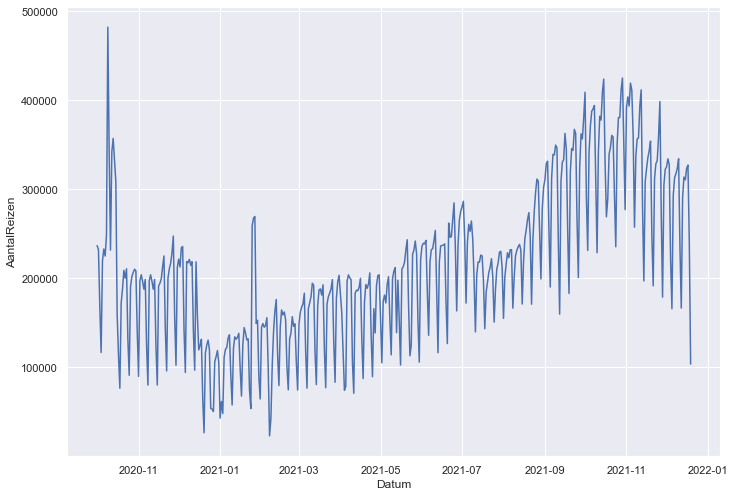

In [12]:
# travels per day in 2020-10 - 2020-12 period
gvb_data_range_very_cleaned_travellers_per_day = gvb_data_range_very_cleaned.groupby(['Datum']).sum().reset_index()

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="Datum", y="AantalReizen", data=gvb_data_range_very_cleaned_travellers_per_day);

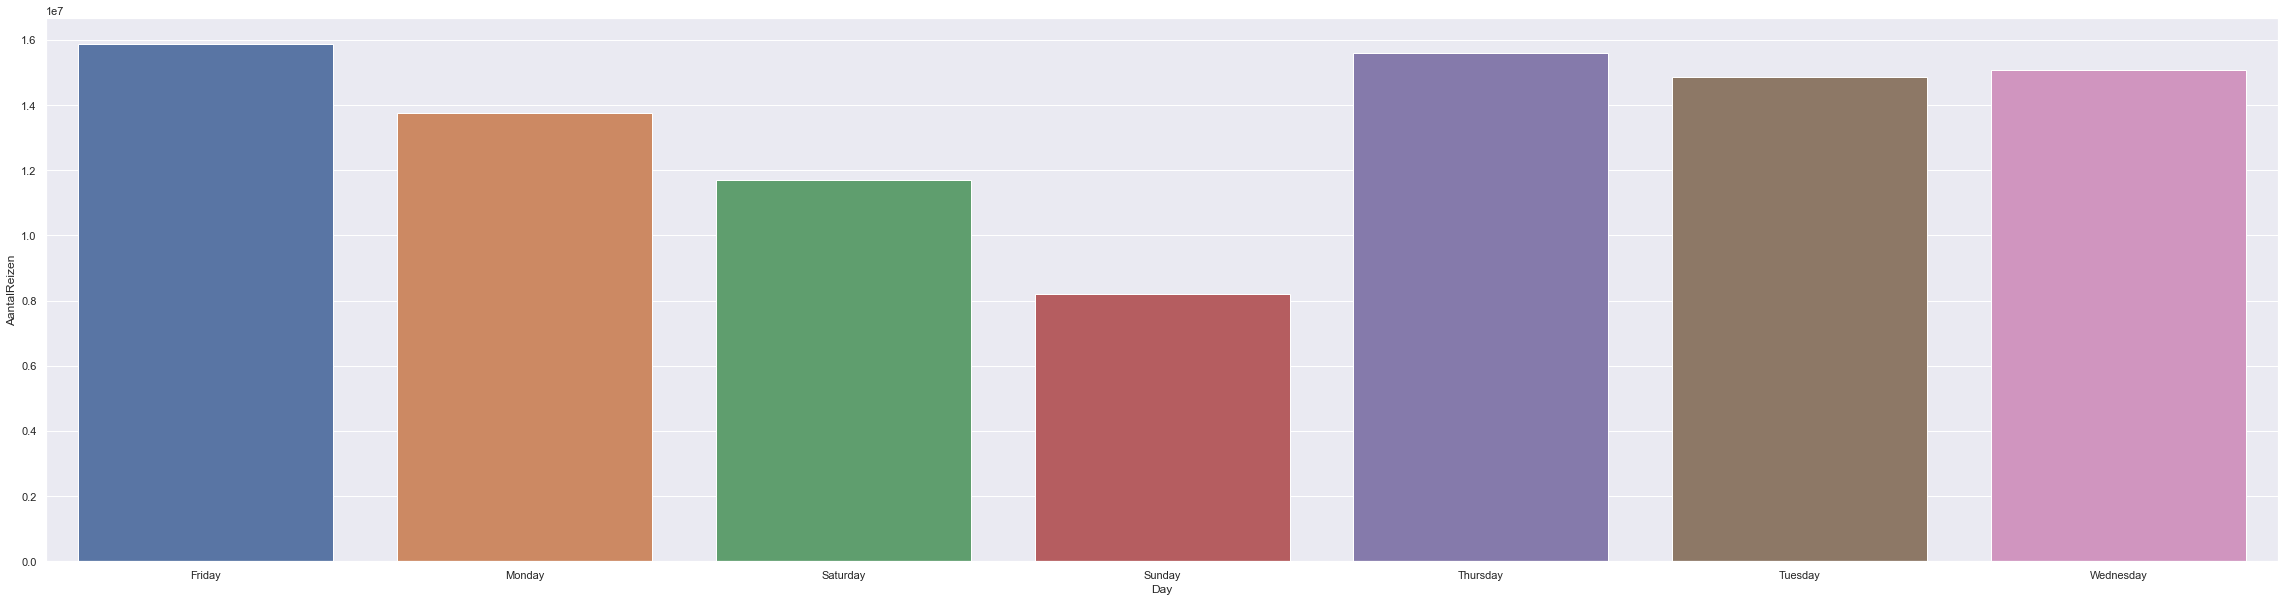

In [13]:
# Travels per day --> Sundays less public transport
gvb_data_range_very_cleaned_travellers_per_day['Day'] = gvb_data_range_very_cleaned_travellers_per_day[['Datum']].apply(lambda x: dt.datetime.strftime(x['Datum'], '%A'), axis=1)
range_summed_per_day = gvb_data_range_very_cleaned_travellers_per_day.groupby('Day').sum().reset_index()

plt.figure(figsize=(40,10))
sns.barplot(x="Day", y="AantalReizen", data=range_summed_per_day);


# Calculate stations near park

In [14]:
# Create DF with all stations with their lon and lat
stations_lon_lat = gvb_data_range_very_cleaned.drop_duplicates(subset=['AankomstHalteNaam'])[['AankomstHalteNaam', 'AankomstLat', 'AankomstLon']]
stations_lon_lat = stations_lon_lat.set_index('AankomstHalteNaam')
stations_lon_lat.rename(columns={"AankomstLat": "lat", "AankomstLon": "lng"}, inplace=True)
stations_lon_lat

,lat,lng
AankomstHalteNaam,,
Centraal Station,4.899218,52.378108
Station Diemen-Zuid,4.957133,52.330428
Station Lelylaan,4.834266,52.357663
Station Bijlmer ArenA,4.947135,52.311930
Bullewijk,4.952336,52.306422
...,...,...
Biesbosch,4.946083,52.330738
Durbanweg,4.734370,52.407657
Lorentzlaan,4.931976,52.345829


In [15]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def add_nearby_stations(radius, center_point_dict, add_to_list):
    """
    radius in km
    center_point_dict needs to be a dictionary with the lon and lat from a location
    add_to_list specify to which list this needs to be added (for example vondelpark)
    """
    latpark = center_point_dict[0]['lat']
    lonpark = center_point_dict[0]['lng']

    # check for every station if it is within 1 km distance of the park
    for station in range(len(stations_lon_lat)):
        name_station = stations_lon_lat.iloc[station].name
        latstation = stations_lon_lat.iloc[station].lat
        lonstation = stations_lon_lat.iloc[station].lng

        a = haversine(lonpark, latpark, lonstation, latstation)
        
        if a <= radius:
            add_to_list.append(name_station)

In [16]:
# Center points of all the parks (https://www.latlong.net/)
all_parks = ['vondelpark', 'oosterpark', 'sarphatipark',
               'westerpark', 'rembrandpark', 'erasmuspark']

vondelpark = [{'lat': 4.868648, 'lng': 52.357645}]
oosterpark = [{'lat': 4.920558, 'lng': 52.360098}]
sarphatipark = [{'lat': 4.896375, 'lng': 52.354364}]
westerpark = [{'lat': 4.873437, 'lng': 52.386986}]
rembrandpark = [{'lat': 4.846757, 'lng': 52.364145}]
erasmuspark = [{'lat': 4.851909, 'lng': 52.374808}]

# Create empty list that needs to be filled later
vondelpark_stations = []
oosterpark_stations = []
sarphatipark_stations = []
westerpark_stations = []
rembrandpark_stations = []
erasmuspark_stations = []

# calculate all station within 1 km from the park
add_nearby_stations(1,vondelpark,vondelpark_stations)
add_nearby_stations(1,oosterpark,oosterpark_stations)
add_nearby_stations(1,sarphatipark,sarphatipark_stations)
add_nearby_stations(1,westerpark,westerpark_stations)
add_nearby_stations(1,rembrandpark,rembrandpark_stations)
add_nearby_stations(1,erasmuspark,erasmuspark_stations)

In [17]:
# Example, stations near westerpark
westerpark_stations

['Van Hallstraat',
 'Fred. Hendrikplants.',
 'Assendelftstraat',
 'Spaarndammerstraat',
 'Van Beuningenplein',
 'Nassaukade',
 'De Wittenkade',
 'Van L.Stirumstraat',
 'V.d. Hoopstraat',
 'Kostverlorenstraat',
 'Nassauplein',
 'Haparandaweg',
 'Zaanstraat',
 'Archangelkade']

In [18]:
# convert pd series from string to datetime
def date_convert(date_to_convert):
     return dt.datetime.strptime(date_to_convert, '%H:%M')
    
# take last hour from column UurgroepOmschrijving and convert to datetime
# add one minute to get hour, so 17:00 means 16:00 - 16:59
# cmobine date and hour to make index unique
gvb_data_range_travels = gvb_data_range_very_cleaned.copy()
gvb_data_range_travels['hour'] = gvb_data_range_travels['UurgroepOmschrijving (van aankomst)'].str[-5:].apply(date_convert) + dt.timedelta(minutes=1)
gvb_data_range_travels['hour'] = gvb_data_range_travels['hour'].dt.time
gvb_data_range_travels['date'] = gvb_data_range_travels.apply(lambda r : pd.datetime.combine(r['Datum'],r['hour']),1)
gvb_data_range_travels = gvb_data_range_travels.set_index('date').reset_index()
gvb_data_range_travels = gvb_data_range_travels.drop(columns=['Datum', 'UurgroepOmschrijving (van aankomst)', 'AankomstHalteCode',
                                 'AankomstLat', 'AankomstLon', 'hour'])

gvb_data_range_travels


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # This is added back by InteractiveShellApp.init_path()


,date,AankomstHalteNaam,AantalReizen
0,2020-10-01 01:00:00,Centraal Station,22
1,2020-10-01 17:00:00,Station Diemen-Zuid,139
2,2020-10-01 17:00:00,Centraal Station,1261
3,2020-10-01 17:00:00,Station Lelylaan,205
4,2020-10-01 17:00:00,Station Bijlmer ArenA,554
...,...,...,...
2138165,2021-12-19 14:00:00,Kattenburgerstraat,31
2138166,2021-12-19 14:00:00,Rietlandpark,14
2138167,2021-12-19 14:00:00,Rietlandpark,20
2138168,2021-12-19 14:00:00,Javaplein,14


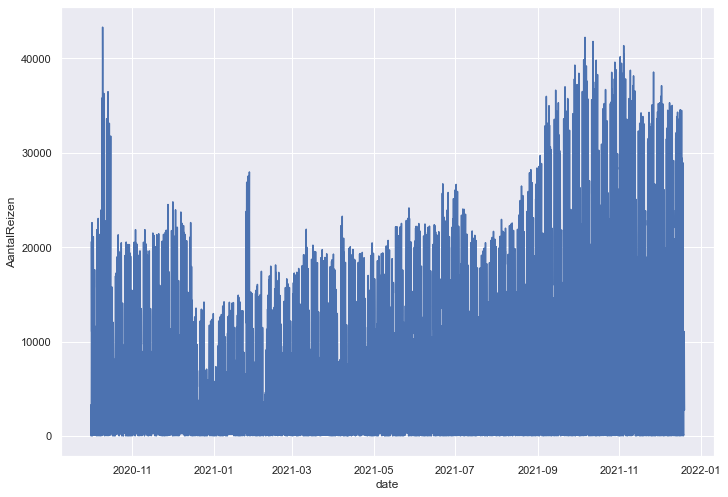

In [19]:
sns.lineplot(x="date", y="AantalReizen", data=gvb_data_range_travels.drop(columns=['AankomstHalteNaam']).groupby('date').sum());


In [20]:
vondelpark_journeys = gvb_data_range_travels[gvb_data_range_travels['AankomstHalteNaam'].isin(vondelpark_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
oosterpark_journeys = gvb_data_range_travels[gvb_data_range_travels['AankomstHalteNaam'].isin(oosterpark_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
sarphatipark_journeys = gvb_data_range_travels[gvb_data_range_travels['AankomstHalteNaam'].isin(sarphatipark_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
westerpark_journeys = gvb_data_range_travels[gvb_data_range_travels['AankomstHalteNaam'].isin(westerpark_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
rembrandpark_journeys = gvb_data_range_travels[gvb_data_range_travels['AankomstHalteNaam'].isin(rembrandpark_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()
erasmuspark_journeys = gvb_data_range_travels[gvb_data_range_travels['AankomstHalteNaam'].isin(erasmuspark_stations)].drop(columns=['AankomstHalteNaam']).groupby('date').sum()

# concatenate all dataframes into one, for later usage
vondelpark_journeys["park"] = "vondelpark"
oosterpark_journeys["park"] = "oosterpark"
sarphatipark_journeys["park"] = "sarphatipark"
westerpark_journeys["park"] = "westergasfabriek"
rembrandpark_journeys["park"] = "rembrandtpark"
erasmuspark_journeys["park"] = "erasmuspark"

frames = [vondelpark_journeys, oosterpark_journeys, sarphatipark_journeys,
          westerpark_journeys, rembrandpark_journeys, erasmuspark_journeys]
all_parks_journeys = pd.concat(frames)


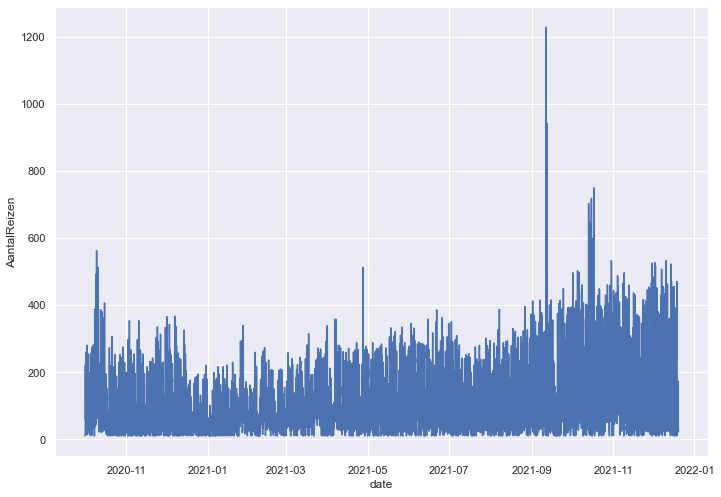

In [21]:
sns.lineplot(x="date", y="AantalReizen", data=westerpark_journeys.reset_index());

In [22]:
# Select Resono vondelpark data, make it (temporary) hourly to see the correlation with amount of journeys.
# Merge resono vondelpark data with gvb data. there are a lot of values that can not be matched, during the
# night trams do not run.

# create list of unique locations and empty list with potential resono x park lists
locations = resono["Location"].unique().tolist()
resono_park_list = []

for location in locations:
    print(location)
    # create dynamic name (https://www.delftstack.com/howto/python/python-dynamic-variable-name/)
    name = f"resono_{location.lower()}"
    name = "_".join(name.split())
    resono_park_list.append(name)
    
    # prepare resono data
    resono_park = resono[resono['Location'] == location]
    resono_park = resono_park.set_index('Start')
    resono_park.index = pd.to_datetime(resono_park.index, utc=True)
    df_resono_park_hourly = resono_park.resample('H').sum().drop(columns = ['Unnamed: 0'])
    df_resono_park_hourly.index = df_resono_park_hourly.index.tz_convert(None)
    df_resono_park_hourly.index = df_resono_park_hourly.index.tz_localize('utc') 
    
    # prepare gvb data of certain park 
    gvb_park = all_parks_journeys[all_parks_journeys["park"] == location.split().pop(0).lower()]
    gvb_park.index = gvb_park.index.tz_localize('utc')
    
    # merge gvb and resono to new dynamic df
    globals()[name] = df_resono_park_hourly.loc["2020-10":].join(gvb_park) 
    globals()[name].index = globals()[name].index.tz_convert(None)

Sarphatipark
Rembrandtpark Noord
Rembrandtpark Zuid
Vondelpark Oost
Vondelpark West
Oosterpark
Westergasfabriek
Erasmuspark


In [23]:
resono_park_list

['resono_sarphatipark',
 'resono_rembrandtpark_noord',
 'resono_rembrandtpark_zuid',
 'resono_vondelpark_oost',
 'resono_vondelpark_west',
 'resono_oosterpark',
 'resono_westergasfabriek',
 'resono_erasmuspark']

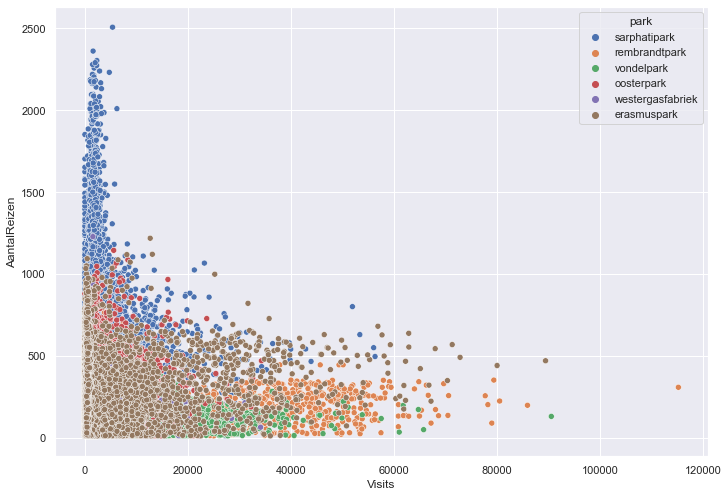

In [24]:
# Correlation is said to be non linear if the ratio of change is not constant. In other words, when all the points on the scatter diagram tend to lie near a smooth curve, the correlation is said to be non linear (curvilinear). This is shown in the figure on the right below.
# Read more: https://www.emathzone.com/tutorials/basic-statistics/linear-and-non-linear-correlation.html#ixzz7HeatLDor
#If a relationship between two variables is not linear, the rate of 
#increase or decrease can change as one variable changes, causing a "curved pattern" in the data. 
#This curved trend might be better modeled by a nonlinear function, such as a quadratic or cubic function, 
#or be transformed to make it linear. Plot 4 shows a strong relationship between two variables. 
# However, because the relationship is not linear, the Pearson correlation coefficient is only +0.244. 
# This relationship illustrates why it is important to plot the data in order to explore any relationships that might exist.

frames = [resono_sarphatipark, resono_rembrandtpark_noord, resono_rembrandtpark_zuid,
         resono_vondelpark_oost, resono_vondelpark_west, resono_oosterpark,
         resono_westergasfabriek, resono_erasmuspark]

all_resono_park = pd.concat(frames)

sns.scatterplot(data=all_resono_park, x="Visits", y="AantalReizen", hue="park");


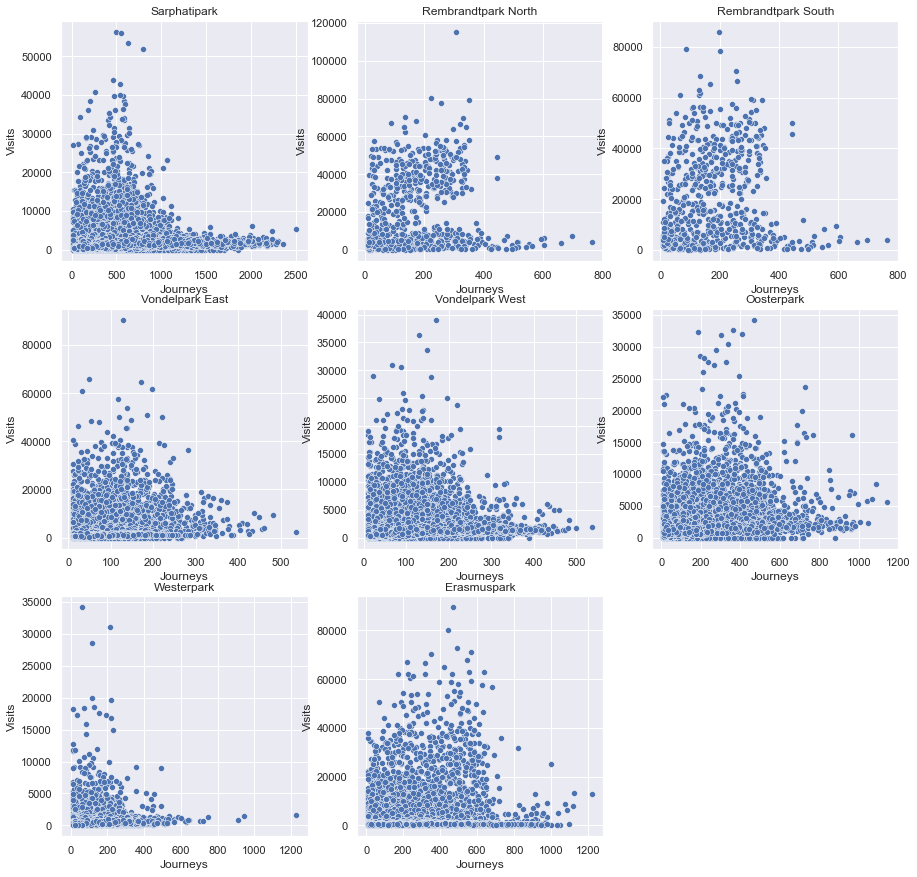

In [68]:
# Show all correlations between park and linear 
f, axes = plt.subplots(3, 3, figsize=(15, 15))

sns.scatterplot(x="AantalReizen", y="Visits", data=resono_sarphatipark, ax=axes[0][0])
axes[0][0].set_title("Sarphatipark")
axes[0][0].set_xlabel("Journeys")

sns.scatterplot(x="AantalReizen", y="Visits", data=resono_rembrandtpark_noord, ax=axes[0][1])
axes[0][1].set_title("Rembrandtpark North")
axes[0][1].set_xlabel("Journeys")

sns.scatterplot(x="AantalReizen", y="Visits", data=resono_rembrandtpark_zuid, ax=axes[0][2])
axes[0][2].set_title("Rembrandtpark South")
axes[0][2].set_xlabel("Journeys")

sns.scatterplot(x="AantalReizen", y="Visits", data=resono_vondelpark_oost, ax=axes[1][0])
axes[1][0].set_title("Vondelpark East")
axes[1][0].set_xlabel("Journeys")

sns.scatterplot(x="AantalReizen", y="Visits", data=resono_vondelpark_west, ax=axes[1][1])
axes[1][1].set_title("Vondelpark West")
axes[1][1].set_xlabel("Journeys")

sns.scatterplot(x="AantalReizen", y="Visits", data=resono_oosterpark, ax=axes[1][2])
axes[1][2].set_title("Oosterpark")
axes[1][2].set_xlabel("Journeys")

sns.scatterplot(x="AantalReizen", y="Visits", data=resono_westergasfabriek, ax=axes[2][0])
axes[2][0].set_title("Westerpark")
axes[2][0].set_xlabel("Journeys")

sns.scatterplot(x="AantalReizen", y="Visits", data=resono_erasmuspark, ax=axes[2][1])
axes[2][1].set_title("Erasmuspark")
axes[2][1].set_xlabel("Journeys")

axes[2,2].set_axis_off()

In [26]:
# Data transformations
all_resono_park['Journeys_interpolated'] = all_resono_park['AantalReizen'].interpolate()
all_resono_park['Journeys_normal'] = all_resono_park['AantalReizen']
all_resono_park['Journeys_log'] = np.log(all_resono_park['Journeys_normal'])
all_resono_park['Journeys_squareroot'] = np.sqrt(all_resono_park['Journeys_normal'])
all_resono_park['Journeys_cuberoot'] = np.cbrt(all_resono_park['Journeys_normal'])
all_resono_park['Journeys_boxcox'] = stats.boxcox(all_resono_park['Journeys_normal'])[0]

all_resono_park

,Visits,AantalReizen,park,Journeys_interpolated,Journeys_normal,Journeys_log,Journeys_squareroot,Journeys_cuberoot,Journeys_boxcox
Start,,,,,,,,,
2020-10-01 00:00:00,261,131.0,sarphatipark,131.000000,131.0,4.875197,11.445523,5.078753,1.022862e+17
2020-10-01 01:00:00,181,33.0,sarphatipark,33.000000,33.0,3.496508,5.744563,3.207534,8.650942e+11
2020-10-01 02:00:00,70,NaN,NaN,39.833333,NaN,NaN,NaN,NaN,NaN
2020-10-01 03:00:00,167,NaN,NaN,46.666667,NaN,NaN,NaN,NaN,NaN
2020-10-01 04:00:00,421,NaN,NaN,53.500000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-01-06 10:00:00,345,NaN,NaN,28.000000,NaN,NaN,NaN,NaN,NaN
2022-01-06 11:00:00,315,NaN,NaN,28.000000,NaN,NaN,NaN,NaN,NaN
2022-01-06 12:00:00,315,NaN,NaN,28.000000,NaN,NaN,NaN,NaN,NaN


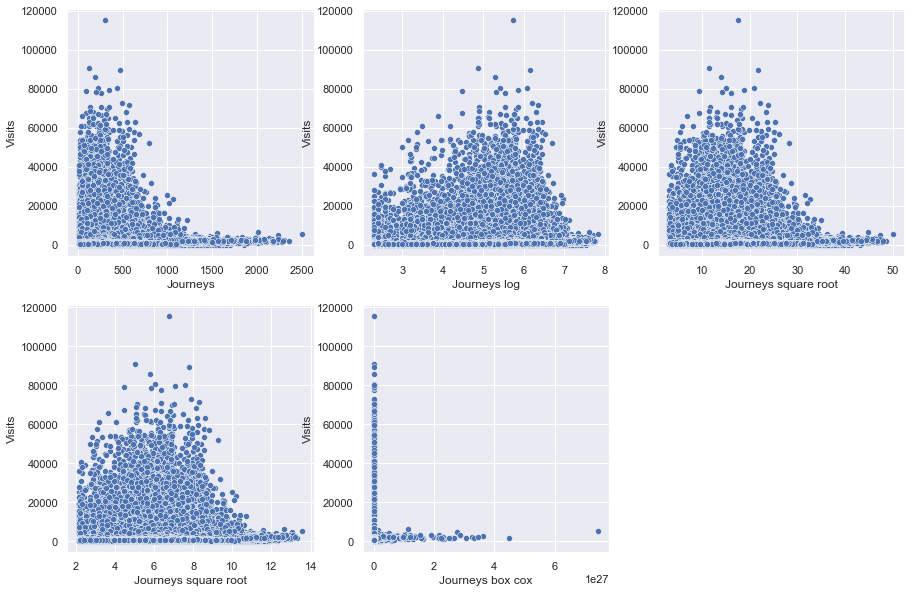

In [67]:
# Show all correlations between park and linear 
f, axes = plt.subplots(2, 3, figsize=(15, 10))

sns.scatterplot(x="Journeys_normal", y="Visits", data=all_resono_park, ax=axes[0][0])
axes[0][0].set_xlabel("Journeys")

sns.scatterplot(x="Journeys_log", y="Visits", data=all_resono_park, ax=axes[0][1])
axes[0][1].set_xlabel("Journeys log")

sns.scatterplot(x="Journeys_squareroot", y="Visits", data=all_resono_park, ax=axes[0][2])
axes[0][2].set_xlabel("Journeys square root")

sns.scatterplot(x="Journeys_cuberoot", y="Visits", data=all_resono_park, ax=axes[1][0])
axes[1][0].set_xlabel("Journeys square root")

sns.scatterplot(x="Journeys_boxcox", y="Visits", data=all_resono_park, ax=axes[1][1])
axes[1][1].set_xlabel("Journeys box cox")

axes[1,2].set_axis_off()

In [29]:
# Make all GVB data 15 min

vondelpark_journeys_15min = vondelpark_journeys.resample('15T').pad()
vondelpark_journeys_15min['AantalReizen'] = vondelpark_journeys_15min['AantalReizen'] / 4

oosterpark_journeys_15min = oosterpark_journeys.resample('15T').pad()
oosterpark_journeys_15min['AantalReizen'] = oosterpark_journeys_15min['AantalReizen'] / 4

sarphatipark_journeys_15min = sarphatipark_journeys.resample('15T').pad()
sarphatipark_journeys_15min['AantalReizen'] = sarphatipark_journeys_15min['AantalReizen'] / 4

westerpark_journeys_15min = westerpark_journeys.resample('15T').pad()
westerpark_journeys_15min['AantalReizen'] = westerpark_journeys_15min['AantalReizen'] / 4

rembrandpark_journeys_15min = rembrandpark_journeys.resample('15T').pad()
rembrandpark_journeys_15min['AantalReizen'] = rembrandpark_journeys_15min['AantalReizen'] / 4

erasmuspark_journeys_15min = erasmuspark_journeys.resample('15T').pad()
erasmuspark_journeys_15min['AantalReizen'] = erasmuspark_journeys_15min['AantalReizen'] / 4

In [30]:
# Select Resono vondelpark data
# Make GVB data 15 minutes

# create list of unique locations and empty list with potential resono x park lists
locations = resono["Location"].unique().tolist()
resono_park_list_15min = []

for location in locations:
    print(location)
    # create dynamic name (https://www.delftstack.com/howto/python/python-dynamic-variable-name/)
    name = f"min15_resono_{location.lower()}"
    name = "_".join(name.split())
    resono_park_list_15min.append(name)
    
    # prepare resono data
    resono_park = resono[resono['Location'] == location]
    resono_park = resono_park.set_index('Start')
    resono_park.index = pd.to_datetime(resono_park.index, utc=True)
    resono_park.index = resono_park.index.tz_convert(None)
    resono_park.index = resono_park.index.tz_localize('utc') 
    
    # prepare gvb data of certain park 
    gvb_park = all_parks_journeys[all_parks_journeys["park"] == location.split().pop(0).lower()]
    gvb_park.index = gvb_park.index.tz_localize('utc')

    # merge gvb and resono to new dynamic df
    globals()[name] = resono_park.loc["2020-10":].join(gvb_park) 
    globals()[name].index = globals()[name].index.tz_convert(None)

Sarphatipark
Rembrandtpark Noord
Rembrandtpark Zuid
Vondelpark Oost
Vondelpark West
Oosterpark
Westergasfabriek
Erasmuspark


In [31]:
resono_park_list_15min

['min15_resono_sarphatipark',
 'min15_resono_rembrandtpark_noord',
 'min15_resono_rembrandtpark_zuid',
 'min15_resono_vondelpark_oost',
 'min15_resono_vondelpark_west',
 'min15_resono_oosterpark',
 'min15_resono_westergasfabriek',
 'min15_resono_erasmuspark']

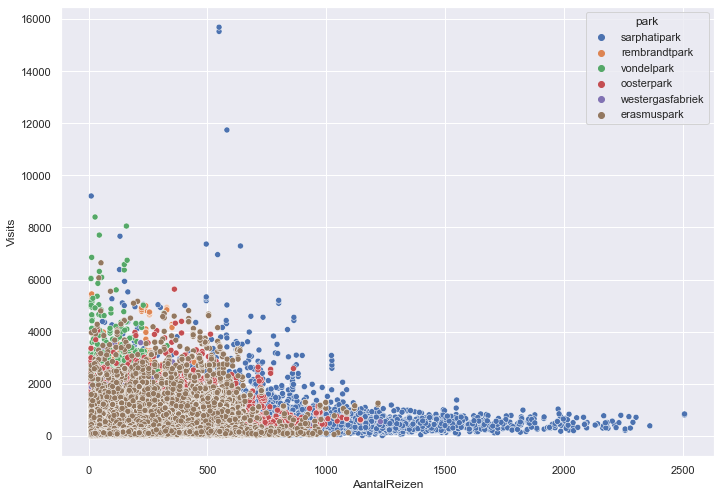

In [118]:
frames = [min15_resono_sarphatipark, min15_resono_rembrandtpark_noord, min15_resono_rembrandtpark_zuid,
         min15_resono_vondelpark_oost, min15_resono_vondelpark_west, min15_resono_oosterpark,
         min15_resono_westergasfabriek, min15_resono_erasmuspark]

min15_all_resono_park = pd.concat(frames)

sns.scatterplot(data=min15_all_resono_park, x="AantalReizen", y="Visits", hue="park");

In [119]:
# make all interpolated between 01:01:00 and 06:30:00 zero because there is no public transport
min15_all_resono_park['Journeys_interpolated'] = min15_all_resono_park['AantalReizen'].interpolate()
min15_all_resono_park.between_time('01:01:00', '06:30:00')['Journeys_interpolated'] = 0
min15_all_resono_park.reset_index()
min15_all_resono_park.drop(columns=['AantalReizen', 'park', 'End_Time', 'End_Time', 'Start_Time', 'Start_Dates', 'End', 'Locationcode', 'End_Dates'], inplace=True)
min15_all_resono_park = min15_all_resono_park.reset_index().set_index('Unnamed: 0').rename(columns={"index": "date"})
min15_all_resono_park.index.name = ""

min15_all_resono_park


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,date,Location,Visits,Journeys_interpolated
,,,,
27807,2020-10-01 00:00:00,Sarphatipark,96,131.0
27993,2020-10-01 00:15:00,Sarphatipark,76,106.5
28223,2020-10-01 00:30:00,Sarphatipark,46,82.0
28446,2020-10-01 00:45:00,Sarphatipark,43,57.5
28666,2020-10-01 01:00:00,Sarphatipark,20,33.0
...,...,...,...,...
1642988,2022-01-06 13:30:00,Erasmuspark,134,28.0
1643172,2022-01-06 13:45:00,Erasmuspark,165,28.0
1643356,2022-01-06 14:00:00,Erasmuspark,179,28.0


<AxesSubplot:xlabel='Journeys_interpolated', ylabel='Visits'>

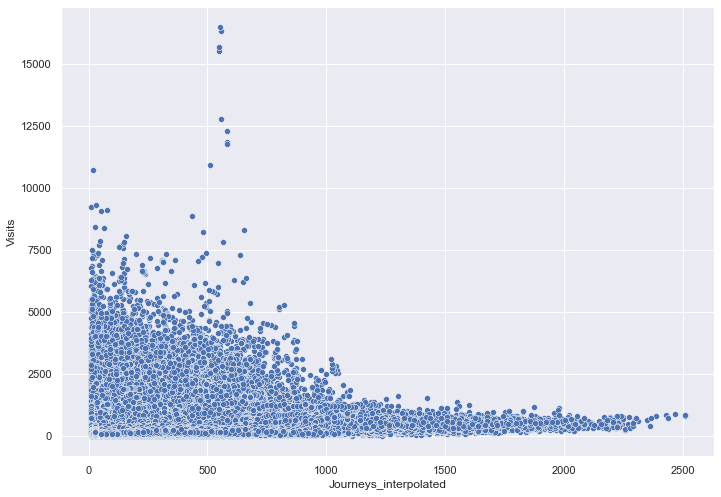

In [122]:
sns.scatterplot(data=min15_all_resono_park, x="Journeys_interpolated", y="Visits")

In [123]:
min15_all_resono_park.to_csv("gvb_resono.csv")

In [133]:
sns.histplot(data=min15_all_resono_park.reset_index(), x="Journeys_interpolated", hue="Locations")




ValueError: Could not interpret value `Locations` for parameter `hue`